In [18]:
import os
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_load import load_dataset
# from plot_utils import plot_series

In [19]:
# Configurar semillas para reproducibilidad
tf.keras.utils.set_random_seed(0)
tf.random.set_seed(51)
np.random.seed(51)
tf.compat.v1.reset_default_graph()

### Carga y preparacion del dataset

In [20]:
series,times = load_dataset('data_h')

In [21]:
series = series.reshape(-1,1) #array bidimensional para utilizar luego el MinMaxScaler

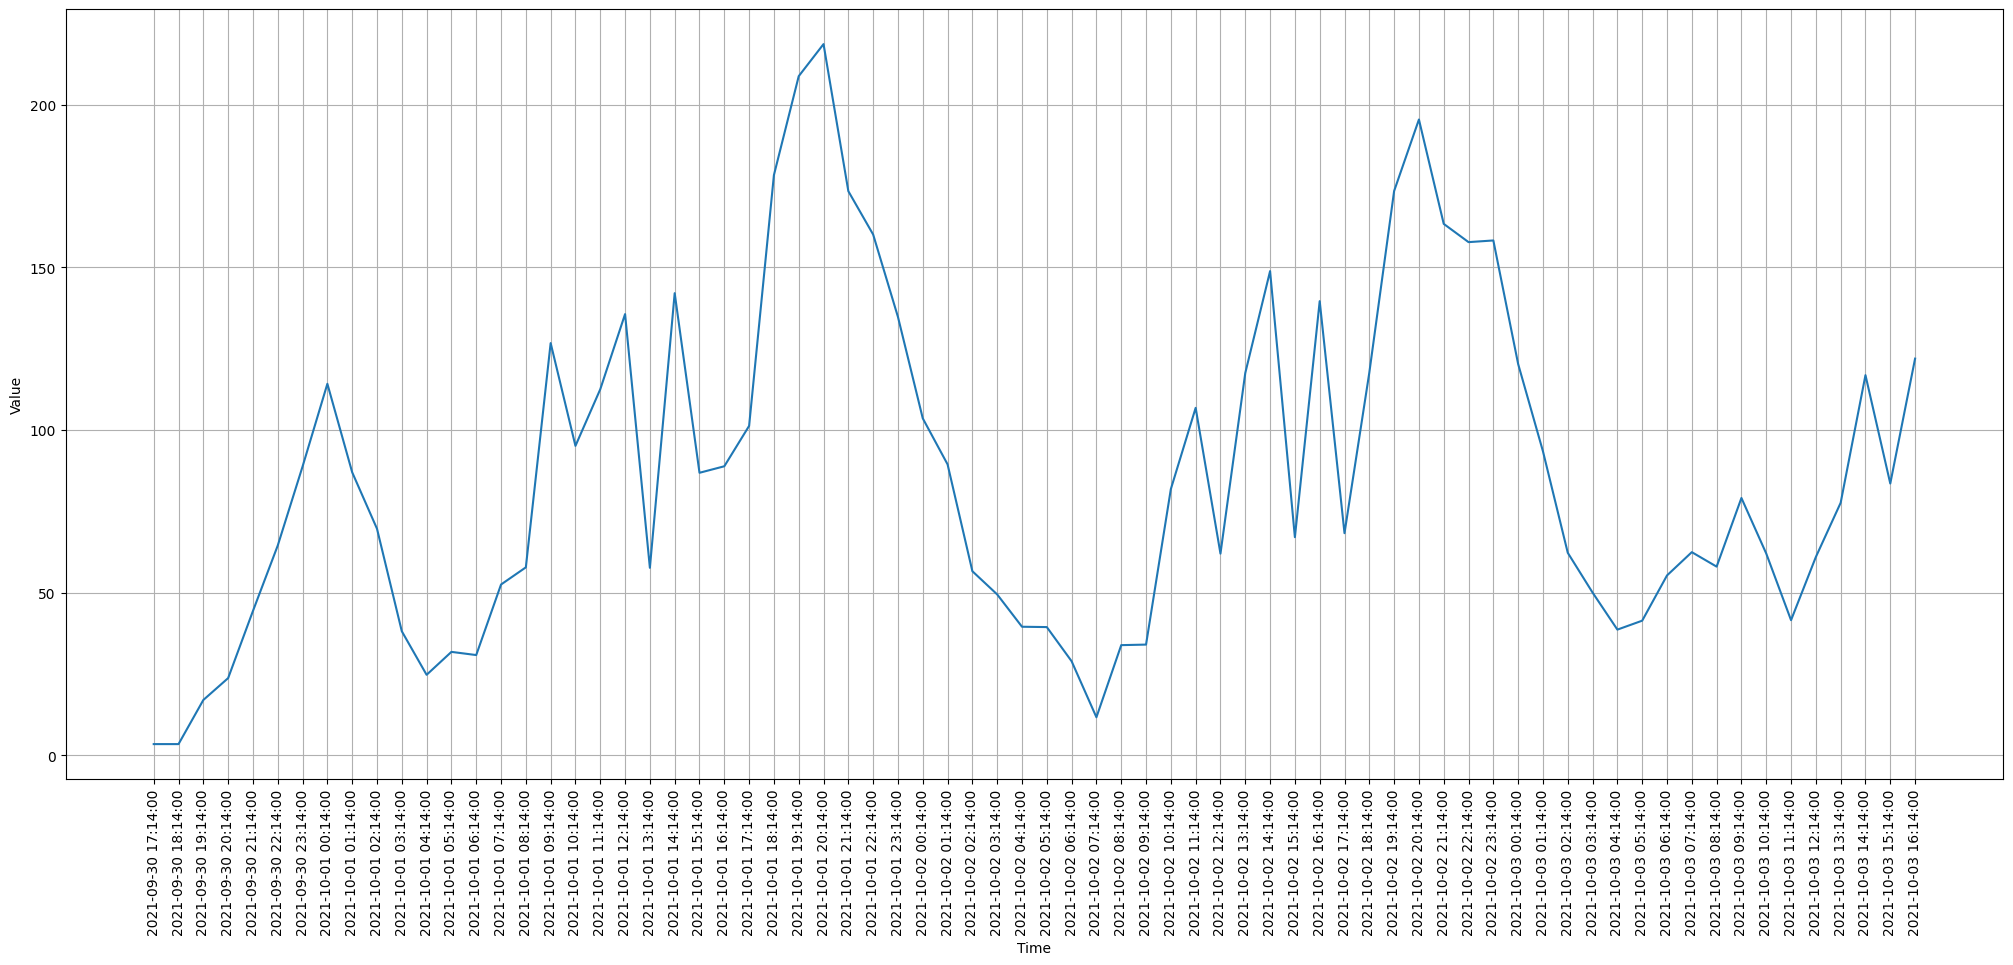

In [5]:
from plots import plot_series
plot_series(times,
            series,
            start=0,
            end = 72)  # with this, we can select a frame to plot

Normalizacion de los datos

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1,1)) # los valores de la loss function son menoros con este rango que con (0,1)
series_scaled = scaler.fit_transform(series)

Determinacion del conjunto de train, validation y test

In [23]:
train_percent = 0.7
val_percent = 0.2
test_percent = 0.1

train_size = int(len(series) * train_percent)
val_size = int(len(series) * val_percent)

x_train = series[:train_size]
x_train_scaled = series_scaled[:train_size]

x_val = series[train_size:train_size + val_size]
x_val_scaled = series_scaled[train_size:train_size + val_size]

x_test = series[train_size + val_size:]
x_test_scaled = series_scaled[train_size + val_size:]

Creacion de los generadores de datos sequenciales para el training de series temporales

In [24]:
window_size = 24 * 4 # 4 days
num_features = 1 # numero de variables, en este caso solo tenemos la demanda electrica, no hay temperatura, meses etc

batch_size = 16 # For training

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(x_train_scaled, 
                                      x_train_scaled, # Esta bien utilizar la demanda como entrada y como objetivo a la vez ya que es una prediccion univariada
                                      length=window_size,
                                      batch_size=batch_size)

validation_generator = TimeseriesGenerator(x_val_scaled,
                                           x_val_scaled,
                                           length=window_size,
                                           batch_size=batch_size)

# normalizamos tambien los datos de test ya que el modelo estara entrenado con datos normalizados por lo que no sera muy consistente realizarlo sin normalizar
test_generator = TimeseriesGenerator(x_test_scaled,
                                           x_test_scaled,
                                           length=window_size,
                                           batch_size=batch_size)

### Construcion del modelo
##### Los modelos que se pueden elegir son:
- LSTM
- ....
- ....

In [26]:
from models import get_model

model_name = 'Bidirectional_LSTM_alt'

model = get_model(model_name,
                   window_size,
                   num_features)

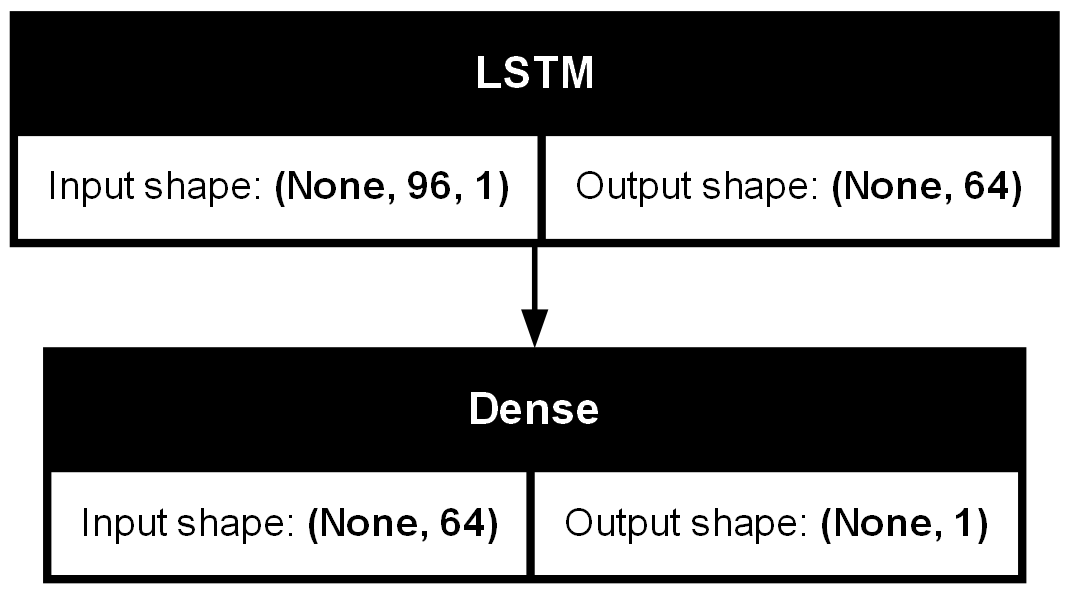

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file= f'Results/{model_name}.png')

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Configuramos los callbacks

Puedo poner callbacks como una lista si quiero utilizar mas de uno. En este caso utilizare ModelCheckpoint y EarlyStopping

In [27]:
from models import configure_callbacks

callbacks = configure_callbacks(early_stopping = True,
                                patience=10, 
                                checkpoint= True, 
                                model_name= model_name, 
                                window_size= window_size,
                                batch_size= batch_size
                                )

Compilamos el modelo

In [28]:
optimizer = 'adam' # Adam(learning_rate=0.001)
metrics = ['mae','mse'] # podemos poner mas metricas como el mae, mse, 

model.compile(loss=tf.keras.losses.Huber(), #ya que es regresion, mejor utilizar mse, mae o huber loss
              optimizer=optimizer,
              metrics=metrics)

### Entrenamiento del modelo

In [29]:
epochs = 30
history = model.fit(train_generator,
                    verbose=1,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/30


  1/378 ━━━━━━━━━━━━━━━━━━━━ 1:35:15 15s/step - loss: 0.0989 - mae: 0.4205 - mse: 0.1977

c:\Users\daviddpp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


378/378 ━━━━━━━━━━━━━━━━━━━━ 64s 130ms/step - loss: 0.0125 - mae: 0.1220 - mse: 0.0250 - val_loss: 0.0092 - val_mae: 0.1005 - val_mse: 0.0184
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - loss: 0.0040 - mae: 0.0665 - mse: 0.0080 - val_loss: 0.0093 - val_mae: 0.0978 - val_mse: 0.0185
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - loss: 0.0036 - mae: 0.0634 - mse: 0.0072 - val_loss: 0.0059 - val_mae: 0.0796 - val_mse: 0.0119
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 52s 138ms/step - loss: 0.0031 - mae: 0.0580 - mse: 0.0061 - val_loss: 0.0054 - val_mae: 0.0771 - val_mse: 0.0108
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 51s 134ms/step - loss: 0.0031 - mae: 0.0585 - mse: 0.0062 - val_loss: 0.0055 - val_mae: 0.0744 - val_mse: 0.0109
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 52s 137ms/step - loss: 0.0033 - mae: 0.0589 - mse: 0.0066 - val_loss: 0.0068 - val_mae: 0.0881 - val_mse: 0.0136
Epoch 7/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 49s 131ms/step - loss: 0.0031 - mae: 0.0577 - mse: 0.

In [26]:
# Create new dir to save results
try:
    os.mkdir(f'Results/train_{model_name}_ws{window_size}_bs{batch_size}_results')
except:
    pass

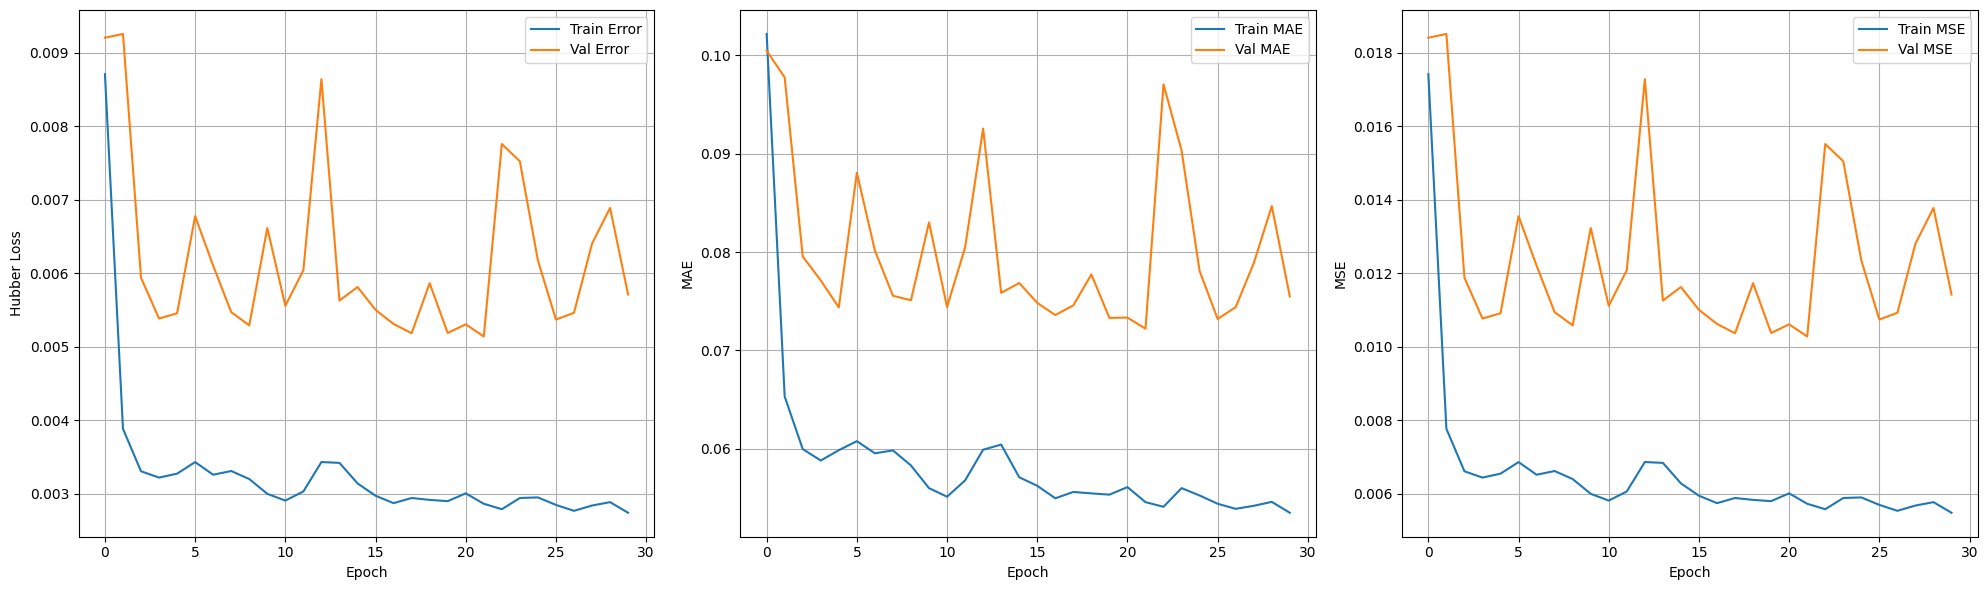

In [30]:
from plots import show_loss_accuracy_evolution
show_loss_accuracy_evolution(history, model_name, window_size, batch_size)

In [74]:
val_loss, val_mae, val_mse = model.evaluate(validation_generator)

 1/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0048 - mae: 0.0728 - mse: 0.0097

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mae: 0.0687 - mse: 0.0094


In [75]:
loss = model.evaluate(validation_generator)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mae: 0.0687 - mse: 0.0094


el metodo fit evalua los datos de train y validacion pero el evaluate tiene sentido utilizarlo para los datos de test que no han sido vistos por el modelo

### Analisis del modelo

Prediccion sobre entrenamiento, validacion y test

In [15]:
from models import predict

train_predict = predict(model,
                        train_generator,
                        scaler)

val_predict = predict(model,
                       validation_generator,
                       scaler)

test_predict = predict(model,
                       test_generator,
                       scaler)

189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
 7/25 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

c:\Users\daviddpp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [16]:
train_rmse = root_mean_squared_error(x_train[window_size:,0], train_predict[:,0])
val_rmse = root_mean_squared_error(x_val[window_size:,0], val_predict[:,0])
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Val RMSE: {val_rmse:.2f}')

Train RMSE: 43.11
Val RMSE: 57.76


In [17]:
train_mae = mean_absolute_error(x_train[window_size:,0], train_predict[:,0]) 
val_mae = mean_absolute_error(x_val[window_size:,0], val_predict[:,0])
print(f'Train MAE: {train_mae:.2f}')
print(f'Val MAE: {val_mae:.2f}')

Train MAE: 31.56
Val MAE: 40.71


In [ ]:
results = {
    'Model': [model_name] * 4,
    'Window Size': [window_size] * 4,
    'Batch Size': [batch_size] * 4,
    'Metric': ['RMSE', 'RMSE', 'MAE', 'MAE'],
    'Data Split': ['Train', 'Val', 'Train', 'Val'],
    'Score': [train_rmse, val_rmse, train_mae, val_mae]
}

results_df = pd.DataFrame(results)

csv_file_path = 'Results/validation_metrics.csv'

# Verificar si el archivo ya existe para decidir cómo guardar
if os.path.exists(csv_file_path):
    # Si el archivo existe, se agrega a él sin encabezado
    results_df.to_csv(csv_file_path, mode='a', header=False, index=False)
else:
    # Si no existe, se crea uno nuevo con encabezado
    results_df.to_csv(csv_file_path, index=False)

Graficamos las predicciones de los 3 conjuntos de datos despues de haber utilizado el predict y transformar inversamente el dataset para obtener la escala de valores original

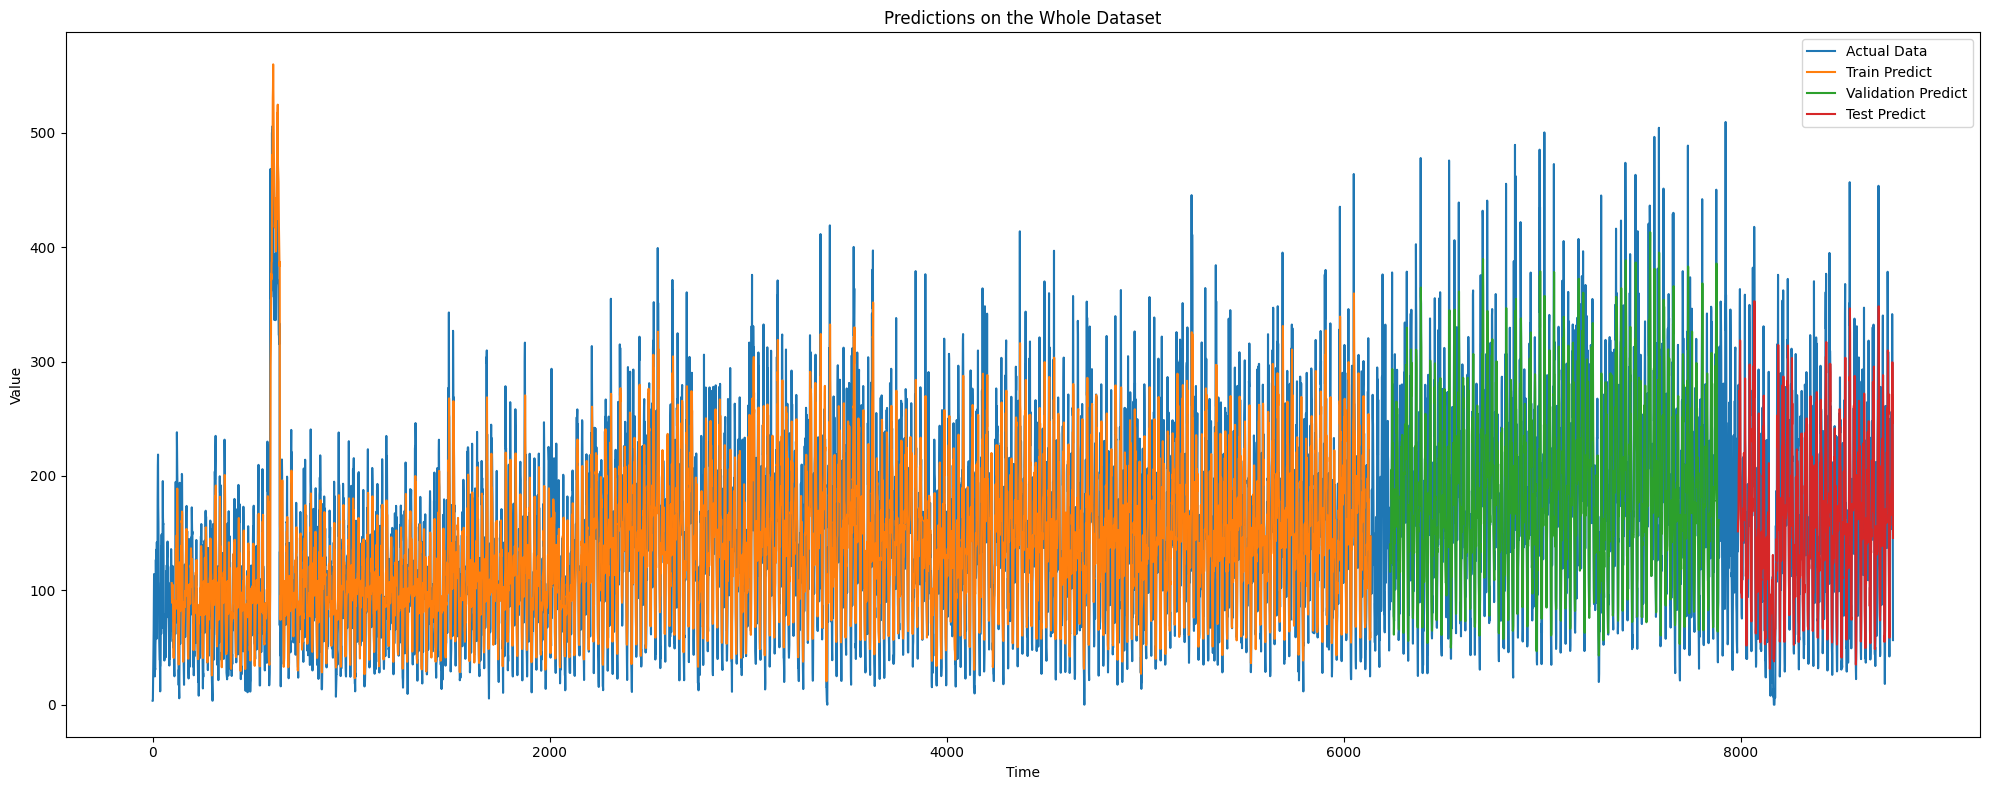

In [21]:
from plots import plot_predictions
plot_predictions(train_predict,
                  val_predict,
                  test_predict,
                  window_size,
                  times,
                  series,
                  x_train,
                  x_val
                  )

Representamos todo el conjunto de train

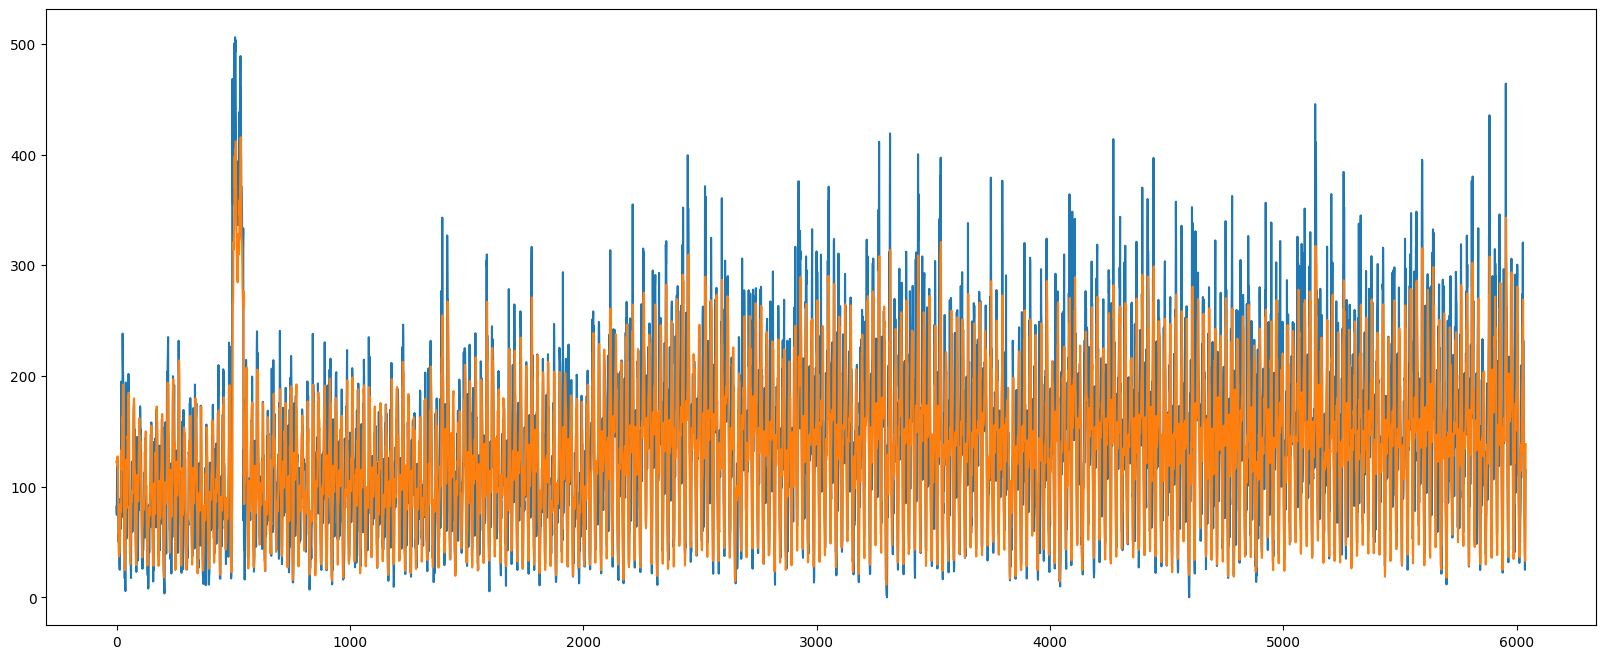

In [34]:
plt.figure(figsize=(20, 8))
plt.plot(x_train[window_size:])
plt.plot(train_predict[:,0])

Representamos todo el conjunto de test

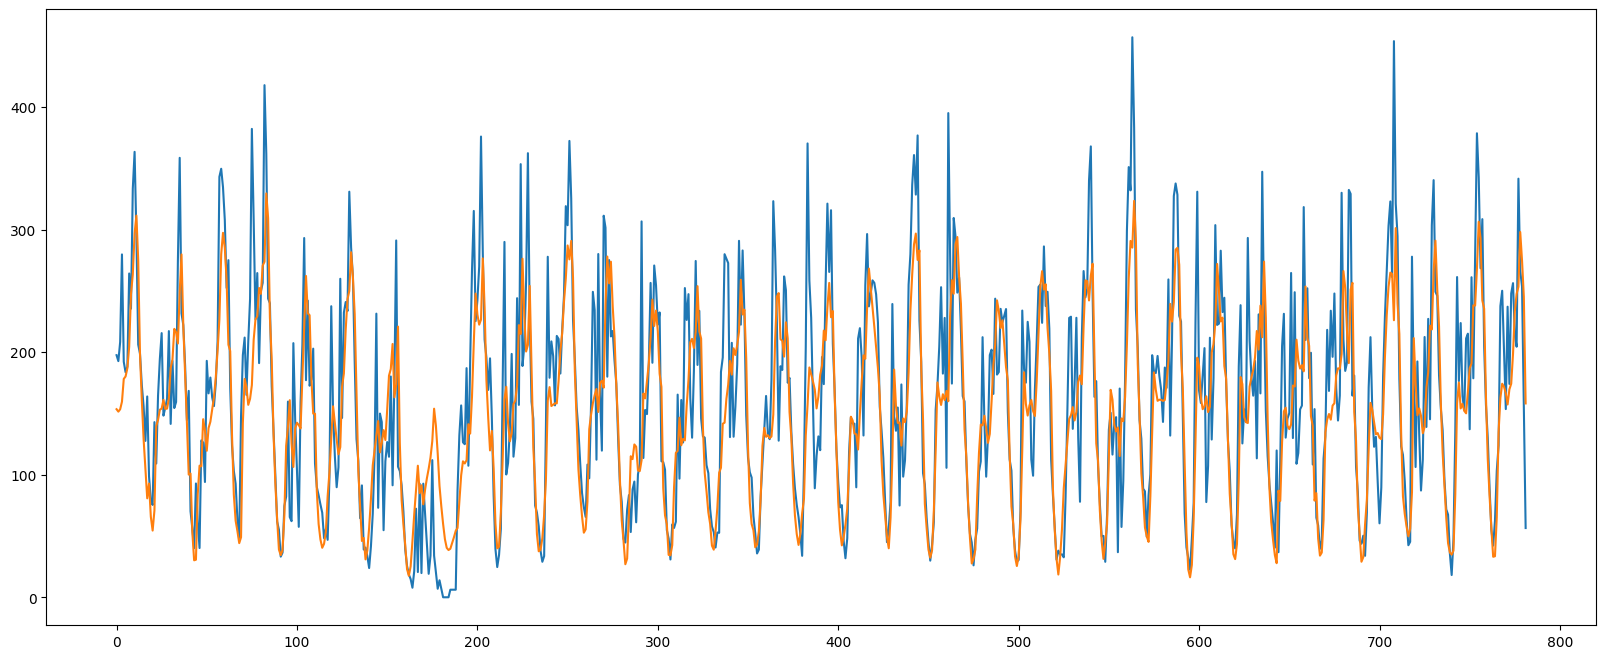

In [33]:
plt.figure(figsize=(20, 8))
plt.plot(x_test[window_size:])
plt.plot(test_predict[:,0])

Grafica de un fragmento del conjunto de train

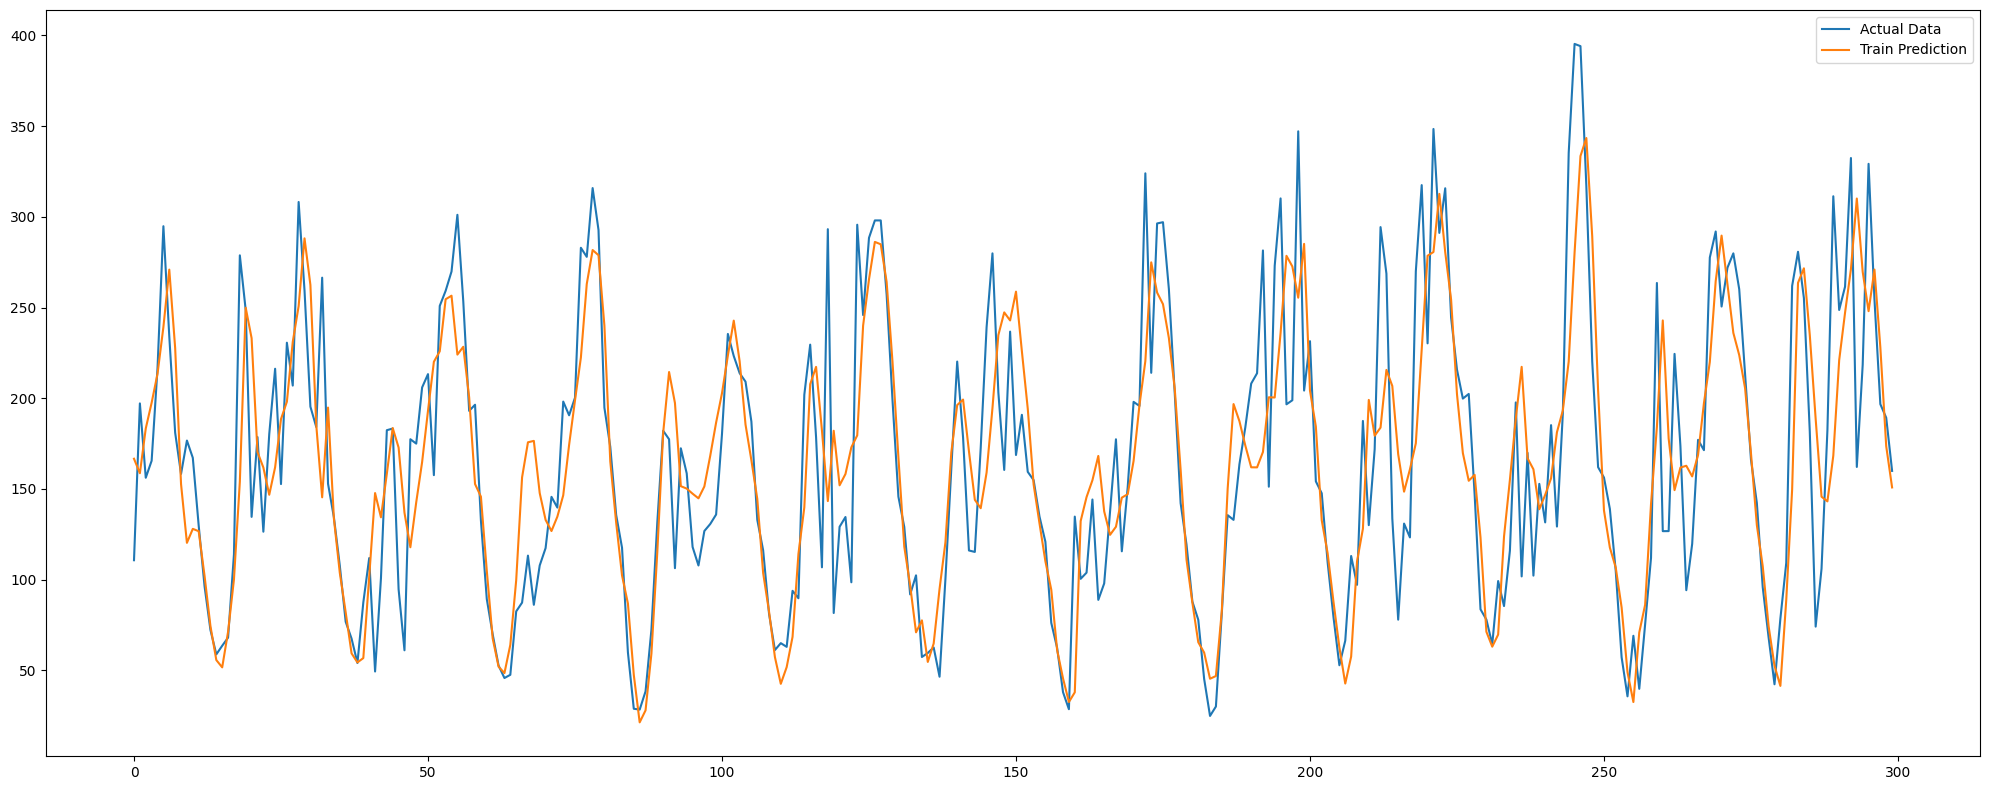

In [79]:
# Train
from plots import raw_data_vs_predictions
start = 5350
end = 5650
raw_data_vs_predictions(x_train, train_predict, window_size, start, end, 'Train')
plt.savefig(f'Results/train_{model_name}_ws{window_size}_bs{batch_size}_results/train_predict.png') # el archivo se sobrescribe aunque no salga guardado en la folder (check cambiando start o/y end)

Grafica de un fragmento del conjunto de test

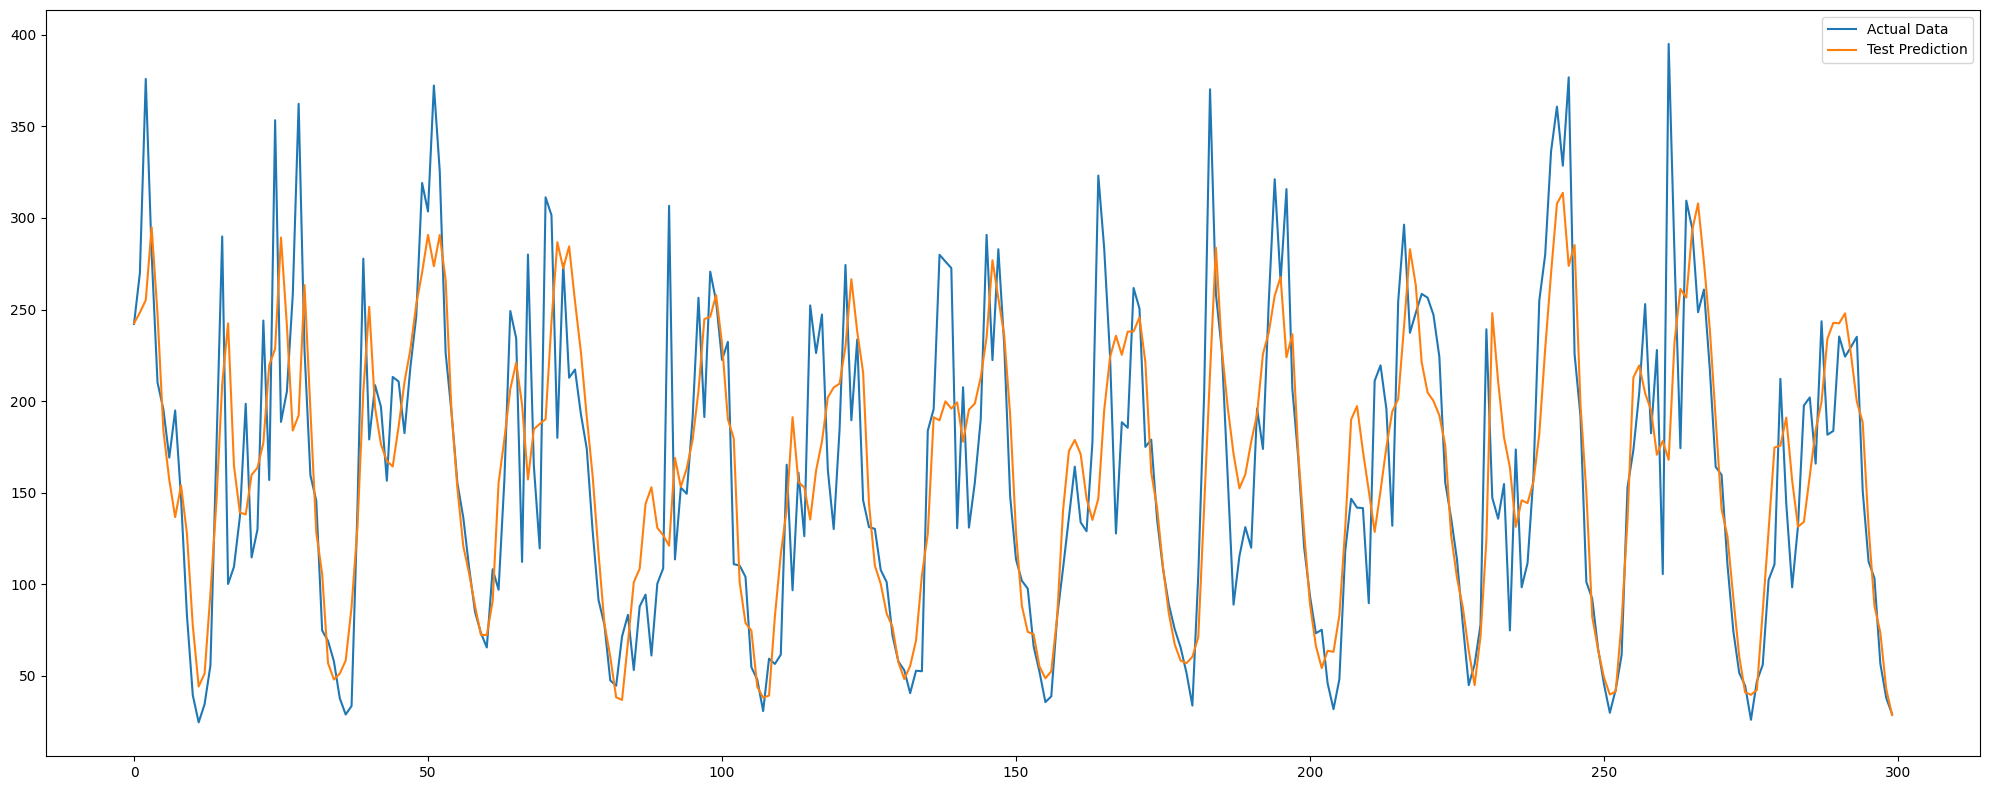

In [82]:
# Test
start = 200 
end = 500 
raw_data_vs_predictions(x_test, test_predict, window_size, start, end, 'Test')
plt.savefig(f'Results/train_{model_name}_ws{window_size}_bs{batch_size}_results/test_predict.png')

Validate the model using RMSE and MAE

In [92]:
def calculate_errors_in_segments(y_true, y_pred, num_segments=4):
    segment_length = len(y_true) // num_segments
    rmses = []
    maes = []
    for i in range(num_segments):
        start = i * segment_length
        end = (i + 1) * segment_length
        if i == num_segments - 1:  # Asegurarse de incluir el resto en el último segmento
            end = len(y_true)
        rmse = root_mean_squared_error(y_true[start:end], y_pred[start:end])
        mae = mean_absolute_error(y_true[start:end], y_pred[start:end])
        rmses.append(rmse)
        maes.append(mae)
    return rmses, maes

In [93]:
# Calcular errores por tramos para el conjunto de entrenamiento
train_rmses, train_maes = calculate_errors_in_segments(x_train[window_size:], train_predict[:,0])

# Calcular errores por tramos para el conjunto de prueba
test_rmses, test_maes = calculate_errors_in_segments(x_test[window_size:], test_predict[:,0])

In [94]:
for i, (train_rmse, train_mae, test_rmse, test_mae) in enumerate(zip(train_rmses, train_maes, test_rmses, test_maes)):
    print(f'Tramo {i+1} - Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}')
    print(f'Tramo {i+1} - Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f}')

Tramo 1 - Train RMSE: 38.16, Train MAE: 27.48
Tramo 1 - Test RMSE: 53.95, Test MAE: 42.01
Tramo 2 - Train RMSE: 41.44, Train MAE: 30.80
Tramo 2 - Test RMSE: 60.28, Test MAE: 45.47
Tramo 3 - Train RMSE: 47.66, Train MAE: 35.47
Tramo 3 - Test RMSE: 51.81, Test MAE: 39.01
Tramo 4 - Train RMSE: 51.43, Train MAE: 37.88
Tramo 4 - Test RMSE: 60.52, Test MAE: 45.64
